In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../.venv/lib/python3.7/site-packages/')
sys.path.append('..')

In [9]:
import matplotlib.pyplot as plt
import random
import numpy as np 
from scipy.stats import norm, multivariate_normal
from typing import Any, Dict, List

# Custom code
from coordination.common.sparse_series import SparseSeries
from coordination.inference.vocalics import DiscreteCoordinationInferenceFromVocalics
from coordination.plot.coordination import plot_discrete_coordination, add_discrete_coordination_bar
from coordination.plot.vocalics import plot_vocalic_features
from coordination.synthetic.coordination_generator import DiscreteCoordinationGenerator
from coordination.synthetic.vocalics_generator import VocalicsGeneratorForDiscreteCoordination

### Binary Coordination (hard coupling)

We start with coordination as a binary variable. Vocalic series A and B are observed at different time scales. A single value of this series at a time step $t$ contains the average value of a specific vocalic feature whithin an utterance that ended at time $t$. If no utterance ended at that time, there's no link between the coordination variable and the vocalic series. That means the model structure is defined according to the data. The existance of coordination affects the coupling between series $A$ and $B$, that is, whether $B_t$ depends on $A_{t-1}$ and vice versa. 

We start by generating synthetic data for a model with the following parameters

$
\begin{align}
p(C_0) &\sim \text{Ber}(0) \\
p(C_t | C_{t-1}) &\sim \text{Bernoulli}\left( 
\begin{cases}
1 - p_{tc},~\text{if}~C_t = C_{t-1} \\
p_{tc},~\text{otherwise}
\end{cases}\right)\\
p(A) = p(B) &\sim \mathcal{N}(0, I) \\
p(A_{t(t_a)}|C_t, B_{t(t_b-1)}) &\sim p(A)^{1-C_t}\mathcal{N}(f(B_{t(t_b-1)}), I)^{C_t} \\
p(B_{t(t_b)}|C_t, A_{t(t_b-1)}) &\sim p(B)^{1-C_t}\mathcal{N}(f(A_{t(t_a-1)}), I)^{C_t}
\end{align}
$

This model makes a series of assumptions:

1. The process starts with no coordination 
2. Coordination is a discrete value (either it exists or not)
3. There's a $p_{tc}$ chance of change in the coordination from one time step to the next
4. Samples from one series are independent of each other, that means series A and B are sampled from their priors (standard normal) if there's no coordination. 
5. We start by setting $f(.)$ to be the identity function, that means coordination is observed as a simple linear coupling betweeen the series.

First we will generate a series of coordination values over time and then we generate series A and B for two vocalic features: pitch and intensity. We assume these features are sampled independently which, in practice, allows us to work with a multivatiate normal with diagonal covariance matrix for the last 3 equations above. 

In [10]:
# Constants
SEED = 0 # For reproducibility
OBSERVATION_DENSITY = 1 # Inference is harder if density is small
NUM_TIME_STEPS = 100
M = int(NUM_TIME_STEPS/2)

In [11]:
# Functions
def plot_coordination(ax: Any, cs: np.ndarray, title: str = ""):
    plt.figure(figsize=(20, 6))
    ax.plot(range(len(cs)), cs, color="green", marker='o')
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_xlabel("Time Step (seconds)")
    ax.set_yticks([0,1])
    ax.set_yticklabels(["No Coordination", "Coordination"])

def plot_vocalic_series(series_a: SparseSeries, series_b: SparseSeries, axs: List[Any], titles: List[str]):
    timesteps_a = [t for t, mask in enumerate(series_a.mask) if mask == 1]
    timesteps_b = [t for t, mask in enumerate(series_b.mask) if mask == 1]
    
    for i in range(series_a.num_series):
        axs[i].set_title(titles[i], fontsize=14, weight="bold")
        axs[i].plot(timesteps_a, series_a.values[i, timesteps_a], color="tab:blue", label="Subject A", marker='o')
        axs[i].plot(timesteps_b, series_b.values[i, timesteps_b], color="tab:orange", label="Subject B", marker='o')
        axs[i].legend()    
        
def plot_coordination_colorbar(coordination_values: np.ndarray, ax: Any):
    colorbar_2x = 1 - coordination_values[np.newaxis, :].repeat(2, axis=0)
    ax.imshow(colorbar_2x, cmap='Greys')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

def equalize_xlim(axs: List[Any], max_value: int):
    gap = int(0.05 * max_value)
    for ax in axs:
        ax.set_xlim([-gap, max_value + gap])

## Syntetic Data

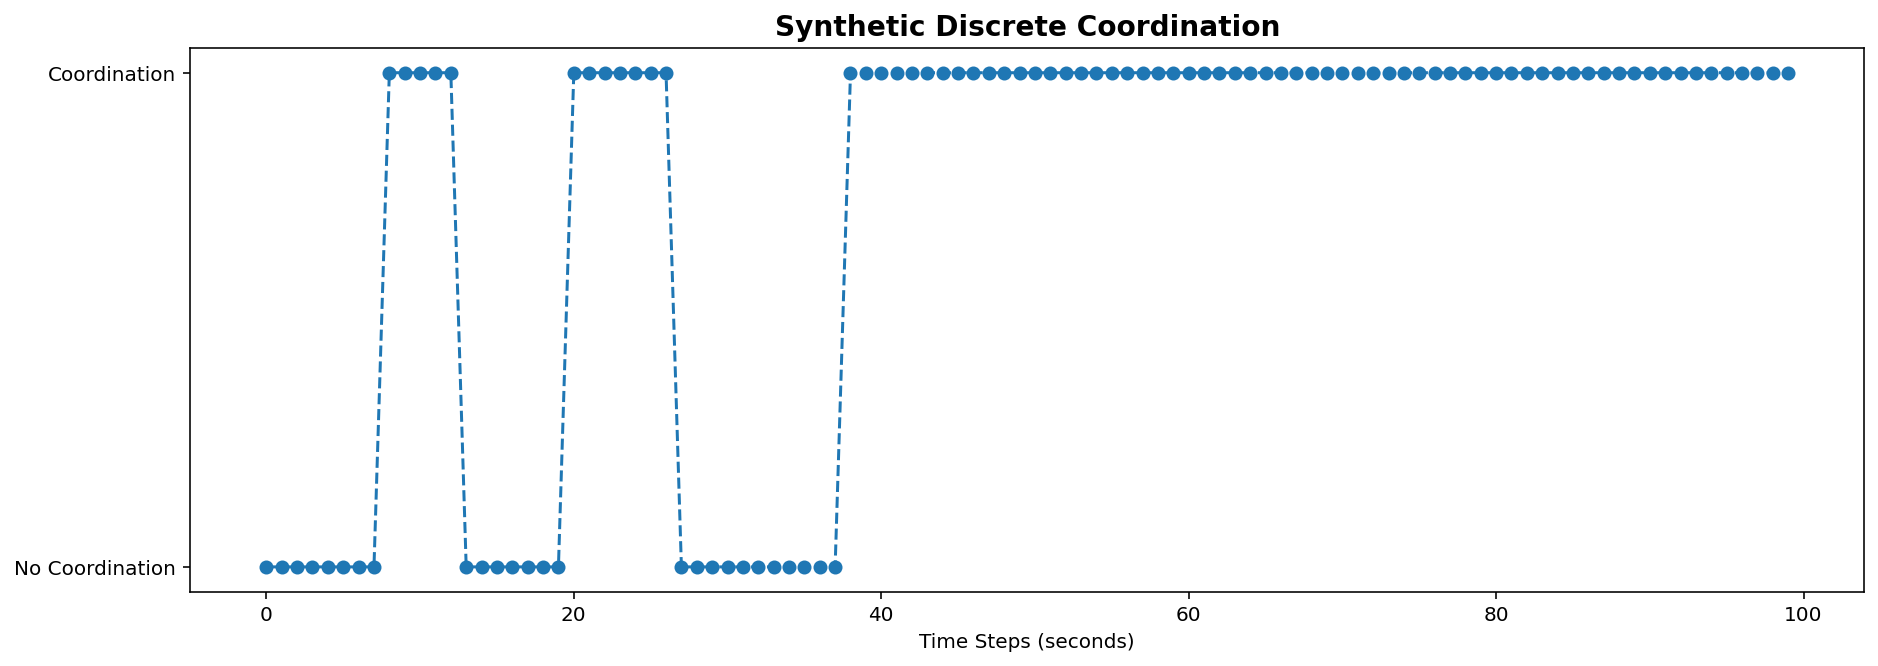

In [12]:
# Samples of coordination starting at 0 and changing with small probability
generator = DiscreteCoordinationGenerator(num_time_steps=NUM_TIME_STEPS, p_coordinated=0, p_transition=0.1)
discrete_cs = generator.generate(SEED)
discrete_cs[M:] = discrete_cs[M]

fig = plt.figure(figsize=(15,5))
plot_discrete_coordination(ax=fig.gca(), 
                           coordination=discrete_cs, 
                           color="tab:blue", 
                           title="Synthetic Discrete Coordination",
                           xaxis_label="Time Steps (seconds)")

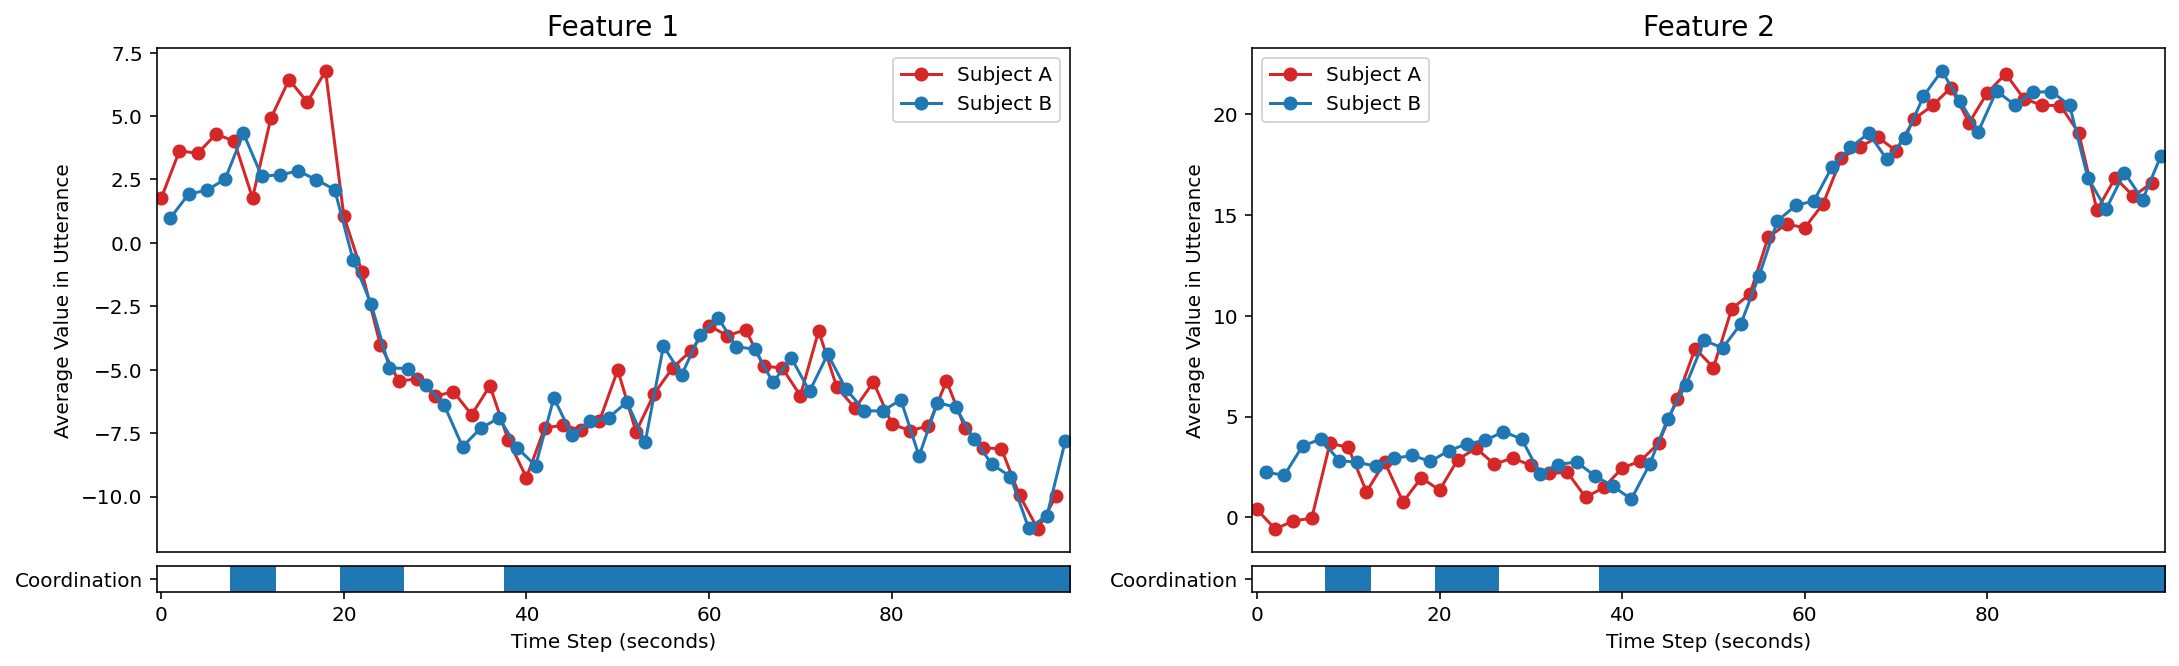

In [18]:
num_features = 2
generator = VocalicsGeneratorForDiscreteCoordination(coordination_series=discrete_cs,
                                                     num_vocalic_features=num_features,
                                                     time_scale_density=OBSERVATION_DENSITY,
                                                     mean_prior_a=np.zeros(num_features),
                                                     mean_prior_b=np.zeros(num_features),
                                                     std_prior_a=np.ones(num_features),
                                                     std_prior_b=np.ones(num_features),
                                                     std_uncoordinated_a=np.ones(num_features),
                                                     std_uncoordinated_b=np.ones(num_features),
                                                     std_coordinated_a=np.ones(num_features),
                                                     std_coordinated_b=np.ones(num_features))
vocalics_a, vocalics_b = generator.generate(SEED)

fig, axs = plt.subplots(1, 2, figsize=(18,5))
plot_vocalic_features(axs, vocalics_a, vocalics_b, ["Feature 1", "Feature 2"], False)
add_discrete_coordination_bar(main_ax=axs[0],
                             coordination_series=[discrete_cs],
                             coordination_colors=["tab:blue"],
                             labels=["Coordination"])
add_discrete_coordination_bar(main_ax=axs[1],
                             coordination_series=[discrete_cs],
                             coordination_colors=["tab:blue"],
                             labels=["Coordination"])

## Inference

Based on the observed vocalic series component, we can infer the coordination at each time step. The joint distribution of coordination and vocalics components is

$
\begin{align}
p(C_{0:T}, A_{0,T_a}, B_{0,T_b}) = p(C_0)\prod^{T}_{t=1}p(C_t|C_{t-1})p(A_t|C_t, B_{t-1})p(B_t|C_t, A_{t-1})
\end{align}
$

Notice that for a certain $t$, $A_t$ and $B_t$ might not have been observed, which means we do not include their terms in the equation above, or they are replaced by 1 which has the same effect. Also, $B_{t-1}$ and $A_{t-1}$ refer to the last time values for the series were observed, thus that might not correspond to the actual $t-1$ time step. 

Inference here can be performed exactly using message passing because of the discrete nature of coordination.


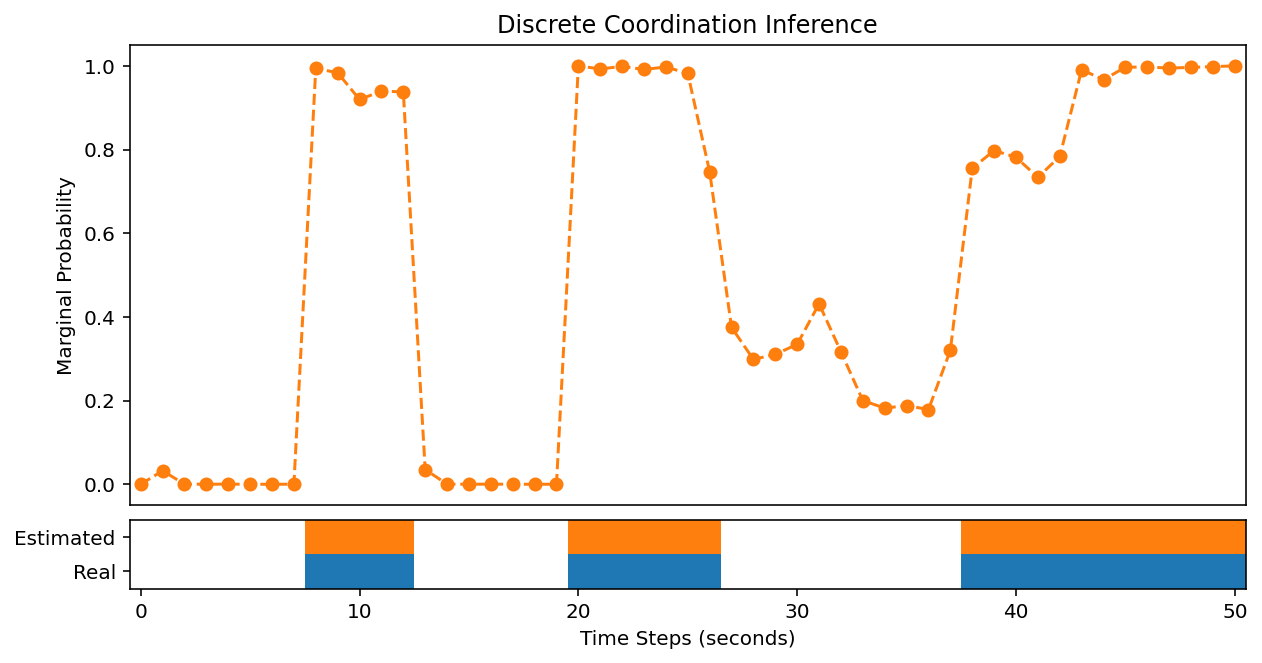

In [14]:
inference_engine = DiscreteCoordinationInferenceFromVocalics(series_a=vocalics_a, 
                                                             series_b=vocalics_b, 
                                                             p_prior_coordination=0, 
                                                             p_coordination_transition=0.1, 
                                                             mean_prior_a=np.array([0,0]), 
                                                             mean_prior_b=np.array([0,0]),
                                                             std_prior_a=np.array([1,1]),
                                                             std_prior_b=np.array([1,1]),
                                                             std_uncoordinated_a=np.array([1,1]),
                                                             std_uncoordinated_b=np.array([1,1]),
                                                             std_coordinated_a=np.array([1,1]),
                                                             std_coordinated_b=np.array([1,1]))
marginal_cs = inference_engine.estimate_marginals()[1]
fig = plt.figure(figsize=(10, 5))
plt.plot(range(M+1), marginal_cs, marker="o", color="tab:orange", linestyle="--")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Marginal Probability")
plt.title("Discrete Coordination Inference")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[discrete_cs[:M+1], np.where(marginal_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:blue", "tab:orange"],
                              labels=["Real", "Estimated"])